In [1]:
import sys

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import logging

import common
import util
importlib.reload(common)
importlib.reload(util)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df, load_df
from common import save_session, load_session

from util import show_importances
from util import split_X_y_all, split_X_y, split_data
from util import empty_features, column_feature, str_contains

from pbar import Pbar

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # converters e.g. for datetime in plots
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Vytvorenie materialized views kvoli obmedzeniu datovej mnoziny

In [3]:
REFRESH_MVIEWS = False

In [5]:
mviews_queries = [
    # iba clanky z monitorov v kategoriach 'english' a 'medical' + publikovane po 'zaciatok-monitoringu' - 4 dni
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles CASCADE;
    CREATE MATERIALIZED VIEW new_articles AS (
    SELECT *
    FROM article
    WHERE monitor_id in (1, 4, 5, 7, 8, 9, 10)
      AND published_at >= '2019-10-10 00:00:00.000000');
    ''',
    
    # maximalne id pozorovania pre danu kombinaciu (url, datum)
    '''
    DROP MATERIALIZED VIEW IF EXISTS article_fb_engagement_per_day CASCADE;
    CREATE MATERIALIZED VIEW article_fb_engagement_per_day AS (
    SELECT max(id) last_id_on_day, related_object_url as url, extracted_at::date as sync_on_day
    FROM feedback_facebook
    GROUP BY url, sync_on_day);
    ''',
    
    # fb popularita + url + rozdiel medzi datumom publikovania a datumom ziskania dat z FB
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles_fb_engagement CASCADE;
    CREATE MATERIALIZED VIEW new_articles_fb_engagement AS (
    SELECT fb.id,
           fb.related_object_url                     as url,
           fb.reaction_count,
           fb.comment_count,
           fb.share_count,
           fb.comment_plugin_count,
           afepd.sync_on_day,
           na.published_at,
           afepd.sync_on_day - na.published_at::date as days_after_publication
    FROM article_fb_engagement_per_day afepd
             JOIN feedback_facebook fb ON fb.id = afepd.last_id_on_day
             JOIN new_articles na ON na.url = afepd.url);
    '''
]

if REFRESH_MVIEWS:
    with engine.connect() as connection:
        for q in mviews_queries:
            connection.execute(q)

In [6]:
main_view = '''
CREATE OR REPLACE VIEW main_articles_view AS
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       raw_body,
       a.published_at,
       extracted_at,
       category,
       other_info,
       coalesce(imgc.cnt, 0)            as image_count,
       coalesce(vidc.cnt, 0)            as video_count,
       aut.name                         as author_name,
       s.id                             as source_id,
       s.name                           as source_name,
       s.url                            as source_url,
       stype                            as source_type,
       is_reliable::integer             as source_is_reliable,
       av.veracity                      as av_veracity,
       coalesce(claims_false, 0)        as av_claims_false,
       coalesce(claims_mostly_false, 0) as av_claims_mostly_false,
       coalesce(claims_mixture, 0)      as av_claims_mixture,
       coalesce(claims_mostly_true, 0)  as av_claims_mostly_true,
       coalesce(claims_true, 0)         as av_claims_true,
       coalesce(av.claims_unknown, 0)   as av_claims_unknown
FROM new_articles a
         JOIN source s on a.source_id = s.id
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt
                    FROM media
                    WHERE media_type = 'image'
                    GROUP BY article_id) imgc ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt
                    FROM media
                    WHERE media_type = 'video'
                    GROUP BY article_id) vidc ON a.id = vidc.article_id
         LEFT JOIN article_veracity av on a.id = av.article_id
WHERE s.is_reliable IS NOT NULL;
'''
with engine.connect() as connection:
     connection.execute(main_view)

In [7]:
# - obsah clanku (+meta)
# - meno autora
# - pocet obrazkov / videii
# - pocet claimov
# - veracity (podla claimov)
# - zdroj (nazov, url)
# - anotacia doveryhodnosti zdroja

df = pd.sql('SELECT * FROM main_articles_view;')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25079 entries, 0 to 25078
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      25079 non-null  int64         
 1   url                     25079 non-null  object        
 2   title                   25079 non-null  object        
 3   perex                   19589 non-null  object        
 4   body                    25045 non-null  object        
 5   raw_body                25077 non-null  object        
 6   published_at            25079 non-null  datetime64[ns]
 7   extracted_at            25079 non-null  datetime64[ns]
 8   category                17017 non-null  object        
 9   other_info              25074 non-null  object        
 10  image_count             25079 non-null  int64         
 11  video_count             25079 non-null  int64         
 12  author_name             25079 non-null  object

In [9]:
# url, popularita na fb, rozdiel sync - publikovanie (max 30 dni)

DAYS_AFTER_POP_CUTOUT = 15

fb = pd.sql(f'''

SELECT url,
       reaction_count,
       share_count,
       comment_count,
       comment_plugin_count,
       sync_on_day,
       days_after_publication
FROM new_articles_fb_engagement
WHERE days_after_publication BETWEEN 0 AND {DAYS_AFTER_POP_CUTOUT}
AND url in (SELECT url FROM main_articles_view);
''')

In [10]:
assert fb.days_after_publication.max() <= DAYS_AFTER_POP_CUTOUT

In [11]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251653 entries, 0 to 251652
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   url                     251653 non-null  object
 1   reaction_count          251653 non-null  int64 
 2   share_count             251653 non-null  int64 
 3   comment_count           251653 non-null  int64 
 4   comment_plugin_count    251653 non-null  int64 
 5   sync_on_day             251653 non-null  object
 6   days_after_publication  251653 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 13.4+ MB


In [12]:
def append_popularity_columns(df, fb):
    df = df.copy()
    fb = fb.copy()
    
    cols = [
        'url',
        'days_after_publication',
        'reaction_count',
        'share_count',
        'comment_count'
    ] 
    
    fb = fb[cols].pivot_table(index='url',
                         columns='days_after_publication')
    fb.columns = [f'fb_ad_{j}_{i}' for i,j in fb.columns.values]
    
    df = df.query("url in @fb.index")
    df = pd.concat((df.set_index('url'), fb), axis=1, join='inner')
    return df.set_index('id')

In [13]:
def append_fb_pop_sum(df):
    df = df.copy()
    for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
        cols = [
            f'fb_ad_{i}_comment_count',
            f'fb_ad_{i}_share_count',
            f'fb_ad_{i}_reaction_count'
        ]
        df[f'fb_popularity_ad_{i}'] = df[cols].apply(np.sum, axis=1)
    return df

In [14]:
xdf = append_popularity_columns(df, fb)
xdf = append_fb_pop_sum(xdf)

df = xdf

2020-05-04 21:20:14,877 : INFO : Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-05-04 21:20:14,878 : INFO : NumExpr defaulting to 8 threads.


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 428781 to 812426
Data columns (total 87 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    20280 non-null  object        
 1   perex                    16137 non-null  object        
 2   body                     20246 non-null  object        
 3   raw_body                 20279 non-null  object        
 4   published_at             20280 non-null  datetime64[ns]
 5   extracted_at             20280 non-null  datetime64[ns]
 6   category                 13716 non-null  object        
 7   other_info               20276 non-null  object        
 8   image_count              20280 non-null  int64         
 9   video_count              20280 non-null  int64         
 10  author_name              20280 non-null  object        
 11  source_id                20280 non-null  int64         
 12  source_name              2

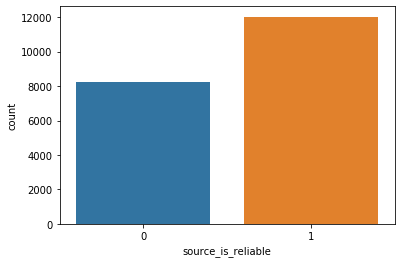

In [16]:
sns.countplot(x='source_is_reliable', data=df)

In [17]:
for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
    col = f'fb_ad_{i}_share_count' 
    
    nan_cnt = df[col].isna().sum()
    not_nan_cnt = df[col].notna().sum()
    
    print(f'd={i}\ttotal={df[col].size}\tNaN_count = {nan_cnt}\tNotNaN_count = {not_nan_cnt}')

d=0	total=20280	NaN_count = 10891	NotNaN_count = 9389
d=1	total=20280	NaN_count = 5873	NotNaN_count = 14407
d=2	total=20280	NaN_count = 4917	NotNaN_count = 15363
d=3	total=20280	NaN_count = 4221	NotNaN_count = 16059
d=4	total=20280	NaN_count = 3749	NotNaN_count = 16531
d=5	total=20280	NaN_count = 3753	NotNaN_count = 16527
d=6	total=20280	NaN_count = 3746	NotNaN_count = 16534
d=7	total=20280	NaN_count = 3804	NotNaN_count = 16476
d=8	total=20280	NaN_count = 4117	NotNaN_count = 16163
d=9	total=20280	NaN_count = 4048	NotNaN_count = 16232
d=10	total=20280	NaN_count = 3798	NotNaN_count = 16482
d=11	total=20280	NaN_count = 3607	NotNaN_count = 16673
d=12	total=20280	NaN_count = 3713	NotNaN_count = 16567
d=13	total=20280	NaN_count = 4014	NotNaN_count = 16266
d=14	total=20280	NaN_count = 4230	NotNaN_count = 16050
d=15	total=20280	NaN_count = 4346	NotNaN_count = 15934


In [18]:
df.source_name.value_counts()

naturalnews.com                  2858
medicinenet.com                  2007
statnews.com                     1394
nytimes.com                      1315
latimes.com                      1281
medicaldaily.com                 1279
foxnews.com                      1122
themindunleashed.com             1041
neurosciencenews.com             1035
webmd.com                         876
thenewsdoctors.com                696
healthnutnews.com                 501
healthy-holistic-living.com       500
healthcentral.com                 451
emedicinehealth.com               358
medicalnewstoday.com              298
ageofautism.com                   264
healthimpactnews.com              230
realfarmacy.com                   225
organicfacts.net                  213
consciouslifenews.com             207
hsionline.com                     206
who.int                           204
naturalhealth365.com              195
infowars.com                      193
collective-evolution.com          145
alliancefora

In [19]:
df.source_is_reliable.value_counts()

1    12018
0     8262
Name: source_is_reliable, dtype: int64

In [20]:
from bs4 import BeautifulSoup
import re
import unicodedata

def clear_text(text):
    if text is None:
        return ''

    text = BeautifulSoup(text, features='html.parser').text
    text = text.lower()
    text = text.replace('\r', '')
    text = text.replace('\n', ' ')
    text = unicodedata.normalize('NFKD', text)

    return text

def clear_column(df, column):
    df[column] = df[column].apply(clear_text)

def clear_columns(df, columns):
    pbar_conf = {
        'refresh_rate': 1,
        'action_names': columns
    }
        
    for c in Pbar(columns, **pbar_conf):
        clear_column(df, c)

In [21]:
clear_columns(df, ['title', 'perex', 'body'])

[==================================================] -- 3 / 3 -- (finished)2 / 33


In [22]:
# drop rows without body
df = df[~df.body.isnull()]
df = df[~df.raw_body.isnull()]
df = df[~df.title.isnull()]
df = df[df.body.str.len() > 0]

In [23]:
df['body'] = df.perex + df.body

In [24]:
def extract_urls(text):
    soup = BeautifulSoup(text, features='html.parser')
    
    tags = soup.find_all('a')
    
    return list(set([tag for tag in map(lambda x: x.get('href'), tags) if tag is not None]))

def remove_urls(text, urls):
    for u in urls:
        text = re.sub(re.escape(u), '', text, flags=re.IGNORECASE)
    
    return text

In [25]:
df['body_urls'] = df.raw_body.apply(extract_urls)
df['body'] = df.apply(lambda r: remove_urls(r.body, r.body_urls), axis=1)

### Save final data

In [26]:
save_df(df, 'final_data.pickle')